In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [11]:
import pandas as pd
import numpy as np
from modules.functions import pymatgen_comp, data_generator
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from joblib import dump,load

In [3]:
demo_df = pd.read_csv('dataset/demo_dataset_true.csv',index_col=0)
demo_df

,Composition,delta_S,d_param,price,FT,density,hardness,uts1200C
0,Hf0.18Ta0.23Ti0.29Nb0.02V0.05W0.24,-1.576208,3.021255,263.947525,12.023840,12.357404,5.220929,0.613781
1,Hf0.41Ta0.13Nb0.3V0.15,-1.276544,3.354286,497.969697,7.555277,11.130573,5.636681,0.709206
2,Hf0.11Zr0.11Nb0.2V0.09Cr0.3W0.19,-1.700934,1.762412,164.378000,13.438005,10.222807,7.241336,0.328560
3,Nb0.36V0.22Cr0.07Mo0.36,-1.254845,2.070033,129.316832,12.847717,8.440787,6.142604,0.796856
4,Hf0.16Zr0.5V0.14W0.2,-1.236930,3.031137,223.510000,9.457498,9.986686,4.926603,0.213467
...,...,...,...,...,...,...,...,...
7429,Zr0.16Nb0.22V0.02Cr0.3Mo0.13W0.17,-1.632215,1.532641,46.502000,14.718450,9.740873,7.154085,0.450552
7430,Ta0.29Nb0.47Cr0.07Mo0.15W0.02,-1.262801,2.337217,138.091000,11.427134,11.104048,5.531199,0.585785
7431,Hf0.01Zr0.31Ti0.24Cr0.31Mo0.14,-1.389949,2.045563,31.521782,11.073776,6.877962,4.504252,0.541833
7432,Ta0.32Nb0.25V0.19Cr0.24,-1.369239,2.055022,196.646000,10.748802,10.334972,5.985502,0.206328


In [12]:
pmg_comps = pymatgen_comp(demo_df['Composition'].values)
dset = data_generator(pmg_comps, use_all_eles=False)
props_list = list(demo_df.columns[1:])
X = dset.real_data

RMSE : 0.003444484734780408
RMSE : 0.001862232409098256
RMSE : 0.004541342274488394
RMSE : 0.002003245517738991
RMSE : 0.0024302299376669032
RMSE : 0.0563855516440715
RMSE : 0.0008726276666119444


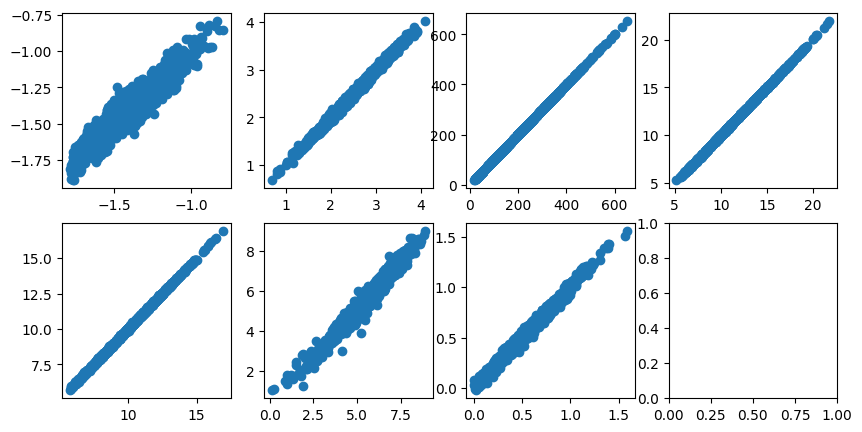

In [13]:
path_to_save = 'saved_surrogates'
fig,ax = plt.subplots(2,4,figsize = (10,5))
ax = ax.ravel()
for i,p in enumerate(props_list):
    y = demo_df.loc[:,p].values
    X_train,X_test, y_train,y_test  = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
    param_grid = {
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.1,0.001,0.0001],
          'learning_rate': ['constant','adaptive'],
          'batch_size' : [16,32,64,128],
          'max_iter':[200,500]
          }
    net =MLPRegressor(hidden_layer_sizes=50, max_iter=500,batch_size=64, alpha = 1e-3)
    pipe = Pipeline([('Scaler', StandardScaler()),('MLPR',net)])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    print(f'RMSE : {mean_squared_error(y_pred,y_test)}')
    ax[i].scatter(y_test,y_pred)
    model_name = f'surrogate_{p}.joblib'
    dump(pipe,os.path.join(path_to_save,model_name))